In [15]:
import sys
sys.path.append('../../')
import helper

import numpy as np
import matplotlib.pyplot as plt
import inspect
import torch

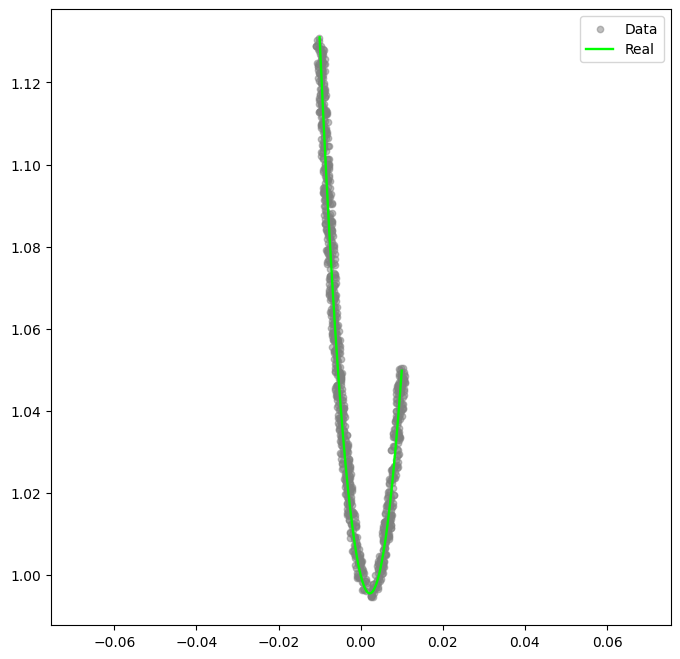

In [16]:
# def f(x, w):
#     return np.sin(w[0] * x) + w[1]
def generate_full_dataset(X, Y, dots_count, radius):
    dataset = []

    x_min = min(X) - radius
    y_min = min(Y) - radius
    x_max = max(X) + radius
    y_max = max(Y) + radius

    method = 'cpu'
    if torch.cuda:
        if torch.cuda.is_available():
            method = 'cuda'

    # print(method)
    device = torch.device(method)
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    Y_tensor = torch.tensor(Y, dtype=torch.float32).to(device)

    while len(dataset) < dots_count:
        x_rand = torch.empty(1).uniform_(x_min, x_max).to(device)
        y_rand = torch.empty(1).uniform_(y_min, y_max).to(device)

        within_radius = (x_rand - X_tensor) ** 2 + (y_rand - Y_tensor) ** 2 <= radius ** 2
        if torch.any(within_radius):
            dataset.append([x_rand.item(), y_rand.item()])

    return np.array(dataset)


def f(x, w):
    return_value = (1 - x * w[0]) ** 2 + 100 * (x * w[1] - x ** 2) ** 2
    return return_value


result_name = '2'
params_dataset = {
    "f_label": inspect.getsource(f),
    "density": 8000,
    "dots_count": 1000,
    "radius": 0.001,
    "dist": 0.01,
    "w0": 2,
    "w1": 3,
    "test_count": 10,
}

X = np.linspace(-params_dataset["dist"], params_dataset["dist"], params_dataset["density"])
Y = np.array([f(x, np.array([params_dataset["w0"], params_dataset["w1"]], dtype=float)) for x in X])

dataset = generate_full_dataset(X, Y, params_dataset["dots_count"], params_dataset["radius"])

dataset_X = dataset[:, 0]
dataset_Y = dataset[:, 1]

helper.print_generated(X, Y, dataset)

In [17]:
def dual_mse(x, y):
    return helper.mse_loss(dataset_X, dataset_Y, np.array([x, y], dtype=float), f)


def simple_mse(w):
    return helper.mse_loss(dataset_X, dataset_Y, w, f)


vectorized_func = np.vectorize(dual_mse)

In [18]:
init_dist_x = 50
init_dist_y = 50
init_density_x = 200
init_density_y = 200

init_x = np.linspace(params_dataset["w0"] - init_dist_x, params_dataset["w0"] + init_dist_x, init_density_x)
init_y = np.linspace(params_dataset["w0"] - init_dist_y, params_dataset["w1"] + init_dist_y, init_density_y)
init_X, init_Y = np.meshgrid(init_x, init_y)
init_Z = vectorized_func(init_X, init_Y)

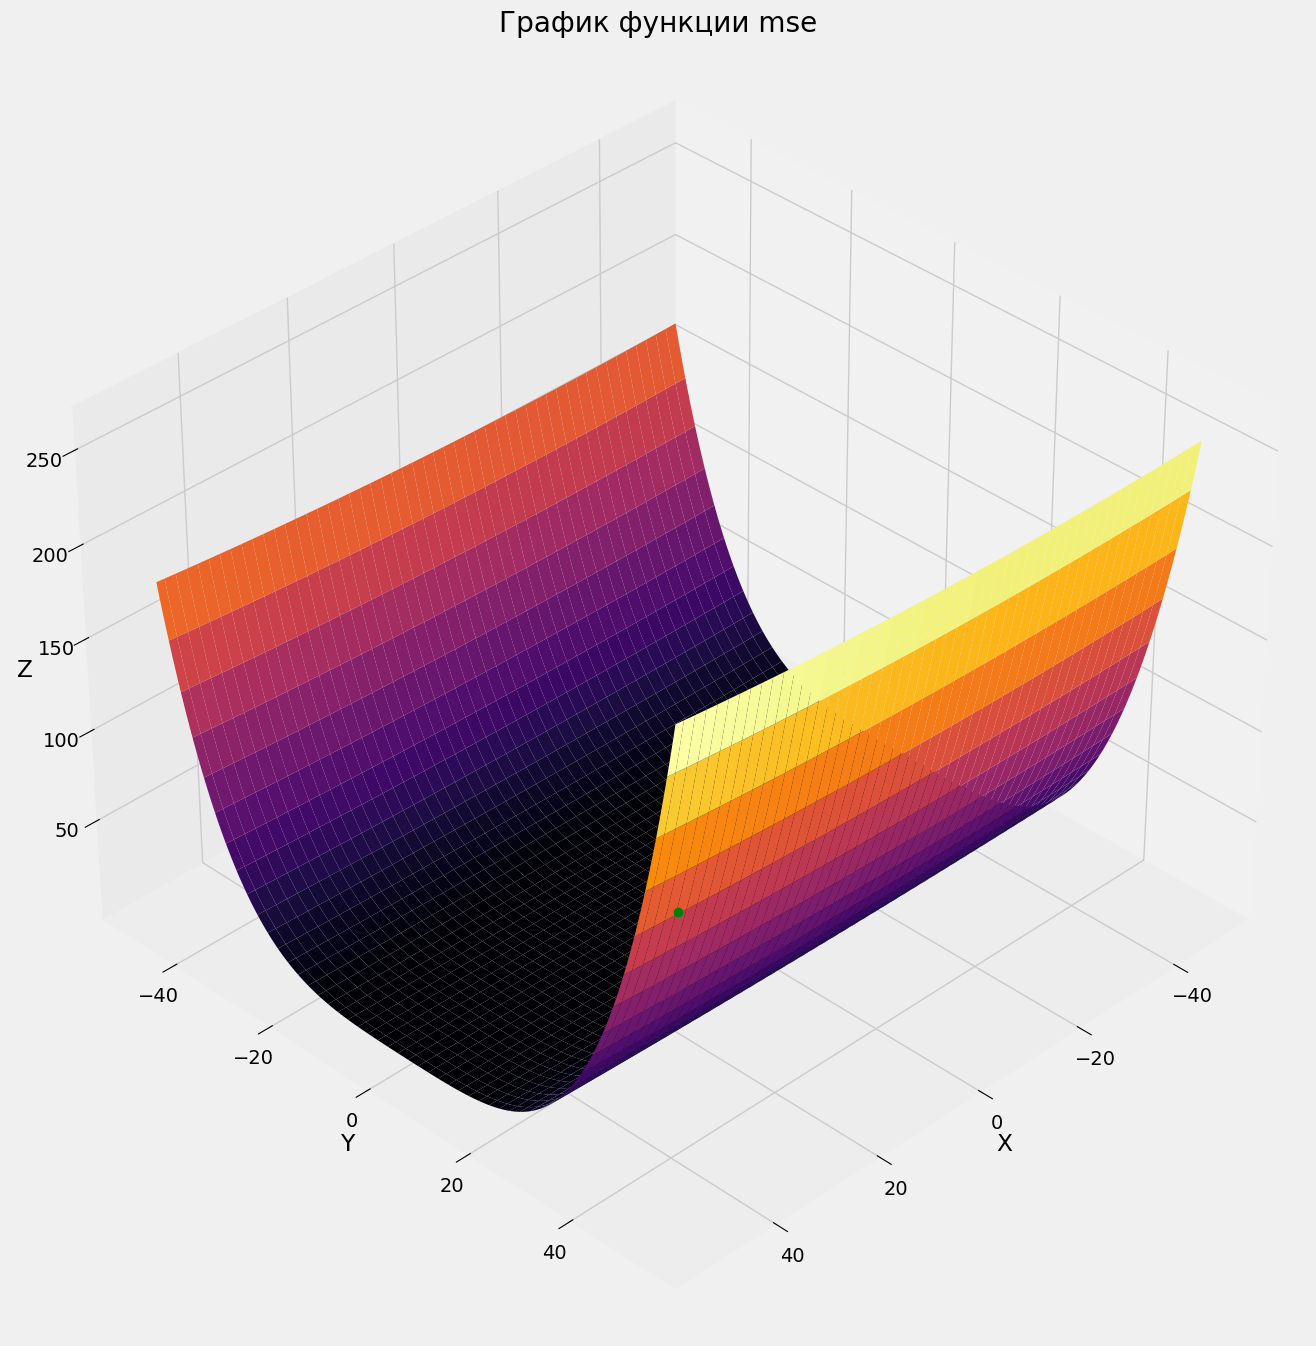

In [19]:
plt.style.use('fivethirtyeight')

# Создаем трехмерную фигуру и оси
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(init_X, init_Y, init_Z, cmap='inferno', edgecolor='none')

ax.plot(params_dataset["w0"], params_dataset["w1"], dual_mse(params_dataset["w0"], params_dataset["w1"]), 'go',
        label='Начальная точка')

ax.view_init(elev=35, azim=45)

# Настройка меток и заголовка
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('График функции mse')

# Отображение графика
plt.show()

In [20]:
def gauss_newton_fast(f, X, Y, initial_params, max_iter=100, epsilon=2e-2, delta=1e-6):
    params = np.array(initial_params)
    history = []

    for iteration in range(max_iter):
        history.append(params.copy())

        if simple_mse(params) < epsilon:
            # print(history)
            return np.array(history)

        # ==========================================================================

        n_samples, n_features = X.shape[0], len(params)
        jacobian = np.zeros((n_samples, n_features), dtype=float)

        for i in range(n_samples):
            jacobian[i] = np.zeros(n_features, dtype=float)

            for j in range(n_features):
                params[j] += delta
                f_plus = f(X[i], params)
                params[j] -= delta
                params[j] -= delta
                f_minus = f(X[i], params)
                params[j] += delta
                jacobian[i][j] = np.divide(f_plus - f_minus, 2 * delta)
        # ==========================================================================

        residuals = Y - f(X, params)
        jacobian_T = jacobian.T

        # ==========================================================================

        update = (np.linalg.inv(jacobian_T @ jacobian) @ jacobian_T) @ residuals
        params += update

        # if np.linalg.norm(update) < epsilon:
        #     return params, iteration + 1

    # print(history)
    # return params, max_iter
    return np.array(history)

In [21]:
import math
import copy


def func(f, X, Y, w, j):
    x = X[j]
    value = Y[j]

    return f(x, w) - value


def derivative(f, X, Y, w, i, j, delta=1e-6):
    w1 = np.copy(w)
    w2 = np.copy(w)

    w1[i] -= delta
    w2[i] += delta

    obj1 = func(f, X, Y, w1, j)
    obj2 = func(f, X, Y, w2, j)

    return (obj2 - obj1) / (2 * delta)


def jacobian(f, X, Y, w, delta):
    rowNum = len(X)
    colNum = len(w)

    Jac = np.zeros((rowNum, colNum))

    for i in range(rowNum):
        for j in range(colNum):
            Jac[i][j] = derivative(f, X, Y, w, j, i, delta)

    return Jac


def dog_leg(f, X, Y, initial_params, max_iter=100, epsilon=2e-2, delta=1e-6, radius=1.5):
    e1 = epsilon  # 1e-12
    e2 = epsilon  # 1e-12
    e3 = epsilon  # 1e-12

    current_params = np.copy(initial_params)

    obj = f(X, current_params) - Y
    Jac = jacobian(f, X, Y, current_params, delta)
    gradient = Jac.T @ obj

    if np.linalg.norm(obj) <= e3 or np.linalg.norm(gradient) <= e1:
        return np.array([current_params])

    history = []

    for iteration in range(max_iter):
        obj = f(X, current_params) - Y
        Jac = jacobian(f, X, Y, current_params, delta)
        gradient = Jac.T @ obj

        history.append(current_params)

        if np.linalg.norm(gradient) <= e1:
            print("stop F'(x) = g(x) = 0 for a global minimizer optimizer.")
            return np.array(history)
        elif np.linalg.norm(obj) <= e3:
            print("stop f(x) = 0 for f(x) is so small")
            return np.array(history)

        alpha = np.linalg.norm(gradient) ** 2 / np.linalg.norm(Jac @ gradient) ** 2
        stepest_descent = -alpha * gradient
        gauss_newton = -1 * np.linalg.inv(Jac.T @ Jac) @ Jac.T @ obj

        beta = 0.0
        dog_leg = np.zeros(len(current_params))

        if np.linalg.norm(gauss_newton) <= radius:
            print('Now GAUSS_NEWTON')
            dog_leg = np.copy(gauss_newton)
        elif alpha * np.linalg.norm(stepest_descent) >= radius:
            dog_leg = (radius / np.linalg.norm(stepest_descent)) * stepest_descent
        else:
            a = alpha * stepest_descent
            b = np.copy(gauss_newton)
            c = a.T @ (b - a)

            if c <= 0:
                beta = (math.sqrt(math.fabs(
                    c * c + np.linalg.norm(b - a, 2) * (radius * radius - np.linalg.norm(a) ** 2))) - c) / (np.linalg.norm(
                    b - a, 2) + e3)
            else:
                beta = (radius * radius - np.linalg.norm(a, 2)) / (
                        math.sqrt(
                            c * c + np.linalg.norm(b - a, 2) * max(0, radius * radius - np.linalg.norm(a, 2))) - c + e3)
            dog_leg = alpha * stepest_descent + (gauss_newton - alpha * stepest_descent) * beta

        print(f'dog-leg: {dog_leg}')

        if np.linalg.norm(dog_leg) <= e2 * (np.linalg.norm(current_params) + e2):
            return np.array(history)

        new_params = current_params + dog_leg

        print(f'new parameter is: {new_params}\n')

        obj_new = f(X, new_params) - Y

        deltaF = np.linalg.norm(obj, 2) / 2 - np.linalg.norm(obj_new, 2) / 2

        delta_l = 0.0

        if np.linalg.norm(gauss_newton) <= radius:
            delta_l = np.linalg.norm(obj, 2) / 2
        elif alpha * np.linalg.norm(stepest_descent) >= radius:
            delta_l = radius * (2 * alpha * np.linalg.norm(gradient) - radius) / (2.0 * alpha)
        else:
            a = stepest_descent * alpha
            b = copy.copy(gauss_newton)
            c = a.T @ (b - a)

            if c <= 0:
                beta = (math.sqrt(math.fabs(
                    c * c + np.linalg.norm(b - a, 2) * (radius * radius - np.linalg.norm(a, 2)))) - c) / (np.linalg.norm(
                    b - a, 2) + e3)
            else:
                beta = (radius * radius - np.linalg.norm(a, 2)) / (
                        math.sqrt(
                            c * c + np.linalg.norm(b - a) ** 2 * max(0, radius * radius - np.linalg.norm(a, 2))) - c + e3)

            delta_l = alpha * (1 - beta) * (1 - beta) * (np.linalg.norm(gradient) ** 2) / 2.0 + beta * (
                    2.0 - beta) * np.linalg.norm(obj, 2) / 2

        roi = deltaF / delta_l

        if roi > 0:
            current_params = np.copy(new_params)
        if roi > 0.75:
            radius = max(radius, 3.0 * np.linalg.norm(dog_leg))
        elif roi < 0.25:
            radius /= 2.0

            if radius <= e2 * (np.linalg.norm(current_params) + e2):
                print("trust region radius is too small.")
                return np.array(history)

    return np.array(history)

In [22]:
def print_full_grad(f, X, Y, Z, list_result, list_label, title='Спуск на mse функции', elev=35, azim=45,
                    filename='', filename_extension='.png', dpi=1024):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    for i in range(len(list_result)):
        x = list_result[i][:, 0]
        y = list_result[i][:, 1]
        z = np.vectorize(lambda x_dot, y_dot: f(np.array([x_dot, y_dot], dtype=float)))(x, y)
        ax.plot(x, y, marker='.', markersize=10, markerfacecolor='black', zs=z, label=list_label[i], linewidth=2)
        print(
            f'{list_label[i]:15} ==> '
            f'{f(list_result[i][-1]):10f} in [{list_result[i][-1][0]:10f}, {list_result[i][-1][1]:10f}]')

    ax.plot_surface(X, Y, Z, cmap='Spectral')
    ax.view_init(elev=elev, azim=azim)

    # Установка отступа между графиком и значениями осей
    ax.tick_params(pad=10)

    # Добавление легенды
    if len(list_label) > 0:
        ax.legend(loc='upper left')

    # Установка размера шрифта для подписей осей
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='z', labelsize=10)

    # Добавление заголовка и подписей осей
    if title != '':
        plt.title(title)

    ax.set_xlabel('Ось X', labelpad=20.0)
    ax.set_ylabel('Ось Y', labelpad=20.0)
    ax.set_zlabel('Ось f(x, y)', labelpad=20.0)

    if filename != '':
        plt.savefig(filename + filename_extension, dpi=dpi, bbox_inches=0, transparent=True)

    plt.show()

In [23]:
print(dual_mse(params_dataset['w0'], params_dataset['w1']))
start_weight = np.array([-1, 3], dtype=float)

6.57092009734074e-05


In [24]:
history_gauss_newton = gauss_newton_fast(f, dataset_X, dataset_Y, start_weight, epsilon=9e-5)

In [25]:
history_dog_leg = dog_leg(f, dataset_X, dataset_Y, start_weight, epsilon=9e-5, radius=7.5)

print(len(history_dog_leg))

Now GAUSS_NEWTON
dog-leg: [ 2.97447696 -0.02582001]
new parameter is: [1.97447696 2.97417999]

Now GAUSS_NEWTON
dog-leg: [ 0.00010492 -0.01498781]
new parameter is: [1.97458188 2.95919218]

stop F'(x) = g(x) = 0 for a global minimizer optimizer.
3


[[-1.          3.        ]
 [ 1.97447696  2.97417999]]
2
gauss-newton    ==>   0.000064 in [  1.974477,   2.974180]
dog_leg         ==>   0.000063 in [  1.974582,   2.959192]


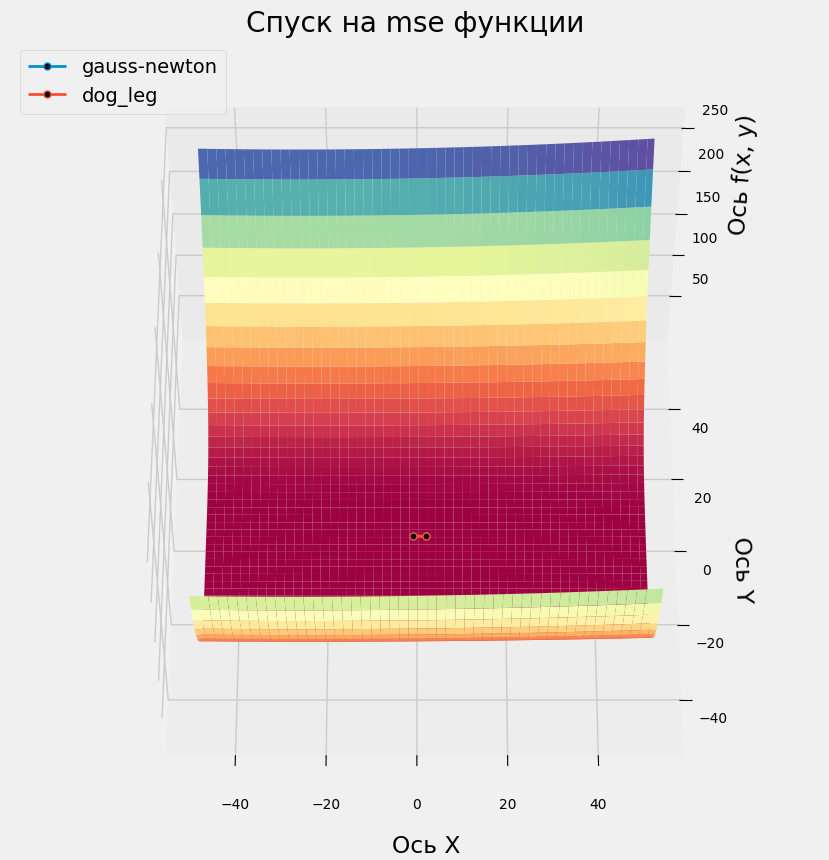

In [26]:
list_result = [history_gauss_newton, history_dog_leg]
list_label = ['gauss-newton', 'dog_leg']

print(history_gauss_newton)
print(len(history_gauss_newton))
plt.style.use('fivethirtyeight')
print_full_grad(simple_mse, init_X, init_Y, init_Z, list_result, list_label, elev=55, azim=-90)

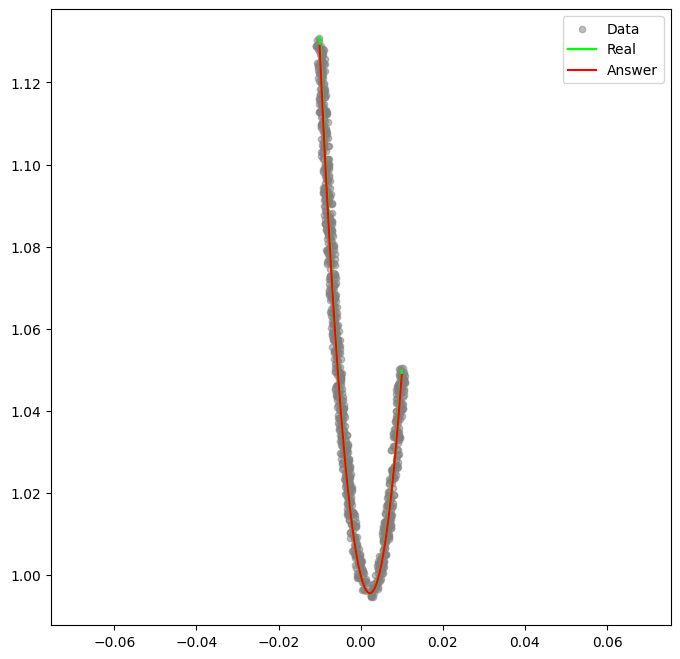

In [27]:
helper.print_generated(X, Y, dataset, f(X, history_gauss_newton[-1]))